In [1]:
# ✅ Cell 1: Setup & Imports
import os
import re
import torch
import pandas as pd
import librosa
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm
from jiwer import wer
from pathlib import Path

from transformers import (
    WhisperProcessor, WhisperForConditionalGeneration,
    Wav2Vec2Processor, Wav2Vec2ForCTC
)

# Setup root paths
PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[1]
DATA_DIR = PROJECT_ROOT / "data" / "turkish"
MODELS_DIR = PROJECT_ROOT / "models"
OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "transcriptions"
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)


c:\Users\berfi\anaconda3\envs\dialect_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ✅ Cell 2: Load Models
whisper_model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-small", cache_dir=str(MODELS_DIR / "whisper-small")
).to("cuda")

whisper_processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", cache_dir=str(MODELS_DIR / "whisper-small")
)

w2v2_tr_model = Wav2Vec2ForCTC.from_pretrained(
    "ceyda/wav2vec2-large-xlsr-53-turkish", cache_dir=str(MODELS_DIR / "wav2vec2-turkish")
).to("cuda")

w2v2_tr_processor = Wav2Vec2Processor.from_pretrained(
    "ceyda/wav2vec2-large-xlsr-53-turkish", cache_dir=str(MODELS_DIR / "wav2vec2-turkish")
)


c:\Users\berfi\anaconda3\envs\dialect_env\lib\site-packages\transformers\configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [3]:
# ✅ Cell 3: Load Turkish Dataset
tsv_path = DATA_DIR / "dev.tsv"
audio_folder = DATA_DIR / "clips"

df = pd.read_csv(tsv_path, sep="\t")[["path", "sentence"]]
print(f"✅ Loaded {len(df)} samples.")


✅ Loaded 11352 samples.


In [4]:
# ✅ Cell 4: Transcription Functions
def transcribe_whisper(filepath):
    try:
        audio, sr = torchaudio.load(filepath)
        audio = torchaudio.functional.resample(audio, sr, 16000)
        inputs = whisper_processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt").input_features.to("cuda")
        decoder_ids = whisper_processor.get_decoder_prompt_ids(language="tr", task="transcribe")
        predicted_ids = whisper_model.generate(inputs, forced_decoder_ids=decoder_ids)
        return whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0].strip()
    except Exception as e:
        return f"[ERROR] {str(e)}"

def transcribe_wav2vec2(filepath):
    try:
        speech, _ = librosa.load(filepath, sr=16000)
        inputs = w2v2_tr_processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
        with torch.no_grad():
            logits = w2v2_tr_model(**inputs.to("cuda")).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        return w2v2_tr_processor.batch_decode(predicted_ids)[0].strip().lower()
    except Exception as e:
        return f"[ERROR] {str(e)}"


In [5]:
# ✅ Cell 5: Transcribe All Samples
results = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    clip_path = audio_folder / row["path"]
    if not clip_path.exists():
        continue

    whisper_pred = transcribe_whisper(str(clip_path))
    w2v2_pred = transcribe_wav2vec2(str(clip_path))

    results.append({
        "filename": row["path"],
        "ground_truth": row["sentence"],
        "whisper_pred": whisper_pred,
        "w2v2_pred": w2v2_pred
    })

df_out = pd.DataFrame(results)
df_out.to_csv(OUTPUTS_DIR / "turkish_transcription_comparison.csv", index=False)
print("✅ Transcriptions saved to:", OUTPUTS_DIR)


100%|██████████| 11352/11352 [39:52<00:00,  4.75it/s] 

✅ Transcriptions saved to: c:\Users\berfi\Documents\GitHub\dialectalwordmining\outputs\transcriptions


In [9]:
# ✅ Cell 6: Filtering and Normalization
df_out_clean = df_out[
    ~df_out["whisper_pred"].str.startswith("[ERROR]") &
    ~df_out["w2v2_pred"].str.startswith("[ERROR]")
].copy()
print(f"🧹 Cleaned {len(df_out_clean)} usable transcriptions.")

def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\sçğıöşü]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df_out_clean["gt_norm"] = df_out_clean["ground_truth"].apply(normalize_text)
df_out_clean["whisper_norm"] = df_out_clean["whisper_pred"].apply(normalize_text)
df_out_clean["w2v2_norm"] = df_out_clean["w2v2_pred"].apply(normalize_text)

whisper_wer = wer(df_out_clean["gt_norm"].tolist(), df_out_clean["whisper_norm"].tolist())
w2v2_wer = wer(df_out_clean["gt_norm"].tolist(), df_out_clean["w2v2_norm"].tolist())

print(f"📊 Normalized Whisper-small WER: {whisper_wer:.3f}")
print(f"📊 Normalized Wav2Vec2-Turkish WER: {w2v2_wer:.3f}")


🧹 Cleaned 11352 usable transcriptions.
📊 Normalized Whisper-small WER: 0.276
📊 Normalized Wav2Vec2-Turkish WER: 0.419


In [13]:
# ✅ Cell 7: Line-Level WERs + Save Unmatched
df_out_clean["whisper_line_wer"] = df_out_clean.apply(
    lambda row: wer(row["gt_norm"], row["whisper_norm"]), axis=1
)
df_out_clean["w2v2_line_wer"] = df_out_clean.apply(
    lambda row: wer(row["gt_norm"], row["w2v2_norm"]), axis=1
)

df_unmatched = df_out_clean[
    df_out_clean["gt_norm"] != df_out_clean["w2v2_norm"]
]

df_unmatched.to_csv(OUTPUTS_DIR / "unmatched_records_turkish.csv", index=False)
print(f"🔍 Saved {len(df_unmatched)} unmatched records.")


🔍 Saved 7743 unmatched records.


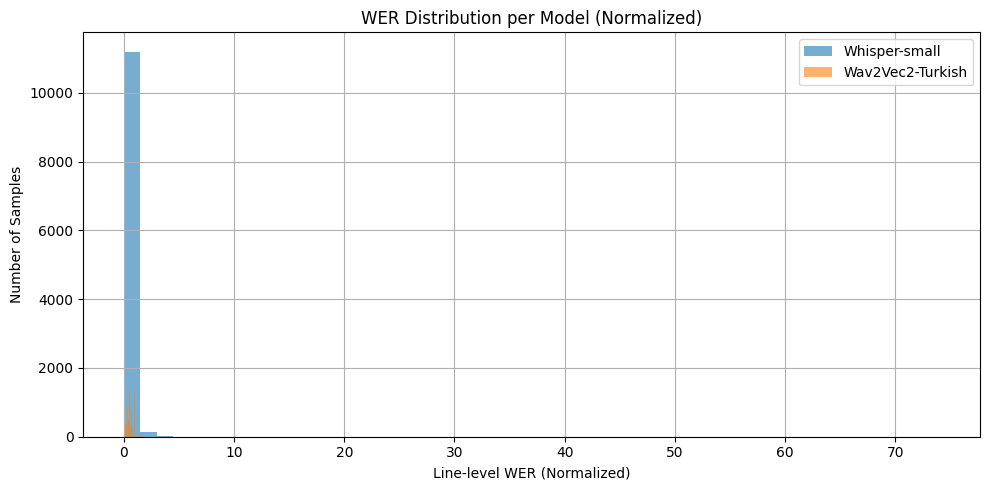

In [14]:
# ✅ Cell 8: Plot WER Distribution
plt.figure(figsize=(10, 5))
plt.hist(df_out_clean["whisper_line_wer"], bins=50, alpha=0.6, label="Whisper-small")
plt.hist(df_out_clean["w2v2_line_wer"], bins=50, alpha=0.6, label="Wav2Vec2-Turkish")
plt.xlabel("Line-level WER (Normalized)")
plt.ylabel("Number of Samples")
plt.title("WER Distribution per Model (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
